# Dataset analysis
Mouna Ammar & Paul Gazel

In [15]:
from pymongo import MongoClient
from bson.son import SON
import pymongo
import pickle
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
client = MongoClient(host='localhost', port=27017, maxPoolSize=200)
print(client.list_database_names())

covidDB = client['Covid_db22'].covid_data22

['Covid_db22', 'admin', 'config', 'local']


In [3]:
covidDB.count_documents({})

43229

In this notebook we are going to analyze the main dataset: the articles. To start, we first need to connect to the mongo database where the articles have been inserted. The first think to highlight is that the total number of articles we have in our database is lower than the one we have in the summary recap. This is due to when inserting into the mongo database we check for duplicates. There is a total of 2 897 articles that were duplicates which brings the total articles we have from 46 126 to 43 229. 

Let's start by plotting and example of article as well as the number of articles over time.

In [4]:
covidDB.find_one()

{'_id': ObjectId('61c24e725eec1850518ce434'),
 'source': {'id': 'nbc-news', 'name': 'NBC News'},
 'author': 'Ilene Prusher',
 'title': "The best gifts don't come in shiny boxes",
 'description': 'This holiday season we have an opportunity to extend our time together beyond watching someone’s face as they tear the wrapping off their booty.',
 'publishedAt': '2021-12-12T10:30:18Z',
 'content': 'Supply chains are all gummed up, leaving some shelves as empty as the toilet paper aisles of March 2020. Prices rose by an alarming 6.8 percent last month, the highest annual inflation rate in almost… [+5211 chars]'}

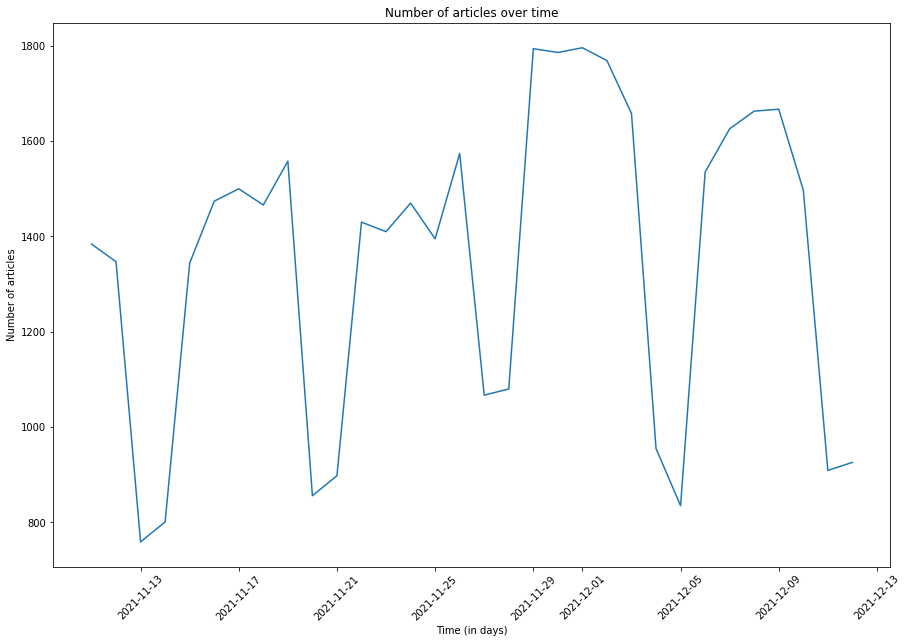

In [16]:
# Start by plotting over time

pipeline = [
    { '$group': {
    '_id': {'$dateToString': { 'date': { '$toDate': '$publishedAt' }, 'format': '%Y-%m-%d' } },
    'count': { '$sum': 1 }
  }},
    {'$sort': SON([('_id', pymongo.ASCENDING)])}
]

res = covidDB.aggregate(pipeline)

x = []
y = []
for sample in res:
    x.append(datetime.strptime(sample['_id'], '%Y-%m-%d'))
    y.append(sample['count'])
    

plt.plot(x, y)
plt.title("Number of articles over time")
plt.xlabel('Time (in days)')
plt.ylabel('Number of articles')
plt.xticks(rotation = 45)
plt.show()

From the article displayed we can see that several columns could be interesting. The 'source' attribute will allow us to find the articles' category, language and country. Both 'Title' and 'Description' will allow to have a grasp on the article's content. Finally the 'content' attribute could be interesting as it contains the article, however we only have the beginning of the articles (First 1/2 sentences).

Now that we have seen the distribution of the articles over time, let's look at how they are distributed among the categories, the countries and the languages seen in the sources analysis.

In [6]:
# Categories
with open('dictionaries/category_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidDB.count_documents({})
    
for category in loaded_dict.keys():
    count = covidDB.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Category', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Category,Number of articles,Percentage
0,general,37925,87.730459
1,business,3668,8.485045
3,sports,1108,2.563094
2,technology,399,0.922992
4,entertainment,65,0.150362
6,science,48,0.111037
5,health,16,0.037012


Looking at the distribution of articles among the different categories we can see that an overwhelming majority is within the 'general' category, leaving little articles for the rest. The categories 'Entertainment', 'Science' and 'Health' may not be relevant to look at as there is too little values to produce a good analysis.

In [7]:
# Languages
with open('dictionaries/language_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidDB.count_documents({})
    
for category in loaded_dict.keys():
    count = covidDB.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Language', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Language,Number of articles,Percentage
0,en,26778,61.944528
7,es,4256,9.845243
2,it,4138,9.572278
10,ru,2377,5.498624
6,pt,1943,4.494668
5,de,1709,3.953365
8,fr,1461,3.379676
1,no,365,0.844341
11,se,181,0.418700
12,nl,16,0.037012


Same thing happens for the languages, the majority of them are in english, and there are some languages that have not enough or no articles which makes impossible an analysis on them. Between these two groups we have a bunch of languages that could interesting to analyze.

In [8]:
# Countries
with open('dictionaries/country_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidDB.count_documents({})
    
for category in loaded_dict.keys():
    count = covidDB.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Country', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Country,Number of articles,Percentage
0,us,15475,35.797728
3,it,4143,9.583844
6,gb,3393,7.848898
11,ar,3201,7.404751
13,in,2808,6.495640
15,ru,2377,5.498624
8,br,1943,4.494668
7,de,1709,3.953365
9,ca,1590,3.678086
12,fr,1461,3.379676


For the countries we have a little better distribution. Once again we have a first group with the U.S far above the rest. There is a few countries that have a decent amount of articles such as Italia, England, Argentina, India... and that could be intersting to study. Once again we have some contestant with not enough articles such as China, Saudi Arabia, Pakistan, Iceland or the Netherlands.

Now that we have seen the distribution of articles among the different group we have. Let's look within those which are the more recurrent words.

In [9]:
# Code to find more recurrent words.

from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
from nltk.corpus import stopwords

stopwords_dict = {
    'en': 'english',
    'it': 'italian',
    'es': 'spanish',
    'fr': 'french',
    'pt': 'portuguese',
    'ru': 'russian',
    'de': 'german',
    'no': 'norwegian',
    'se': 'swedish',
    'nl': 'dutch',
}

def get_counter_from_query(query, attribute, lang='all'):
    my_counter = Counter()
    
    for obj in covidDB.find(query):
        if obj[attribute]:
            # Tokenize and give it to the counter
            tokens = word_tokenize(obj[attribute].lower())
            my_counter.update(tokens)
    
    # remove stop words
    if lang == 'all':
        for stopword_lang in stopwords_dict.keys():
            stops = set(stopwords.words(stopwords_dict[stopword_lang]))
            for word in stops:
                if word in my_counter:
                    del my_counter[word]
    else:
        stopword_lang = lang
        
        stops = set(stopwords.words(stopwords_dict[stopword_lang]))
        for word in stops:
            if word in my_counter:
                del my_counter[word]
    
    # Remove items under size 2 chars
    del_list =['...', '+++']
    for key in my_counter:
        if len(key) <= 2:
            del_list.append(key)

    for item in del_list:
        del my_counter[item]
    
    return my_counter

Let's start by looking at the title attribute with all the articles.

In [10]:
number_most_common = 10
att = 'title'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('covid', 6821), ('covid-19', 5388), ('coronavirus', 3650), ('omicron', 3043), ('casos', 2916), ('new', 2551), ('argentina', 2544), ('reuters', 2298), ('vaccine', 1865), ('noviembre', 1828)]


As expected, the words appearing the most are Covid and Covid-19. We can note that the first 3 words are used to call the virus. Finally the 4th word appearing the most is Omicron which is the new covid variant that appeared the 26th of Novembre (So in the middle of dataset in terms of dates). The fifth word is cases in spanish which probably tells that there is a high number of articles that speaks about covid cases. The word 'new' can be both associated to the new variant as well as new cases so it does not bring much information. Finally the word 'Argentina' comes in 7th position appearing 2544 times while there is only 3201 articles coming from Argentina which mean that they probably mention their country in most of the title. Then comes 'Reuters' an international news organization present in the sources that has 2473 articles in the dataset and that signs them with name which explains the presents of 'reuters' in this list. Then comes 'vaccines' which is a very common article theme and finally 'Noviembre' which is november in spanish as most of the articles we have in the dataset are published in the previous month: November.

In [11]:
number_most_common = 10
att = 'description'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('covid-19', 8876), ('new', 4881), ('variant', 3281), ('said', 3254), ('covid', 3224), ('omicron', 2929), ('número', 2772), ('coronavirus', 2737), ('fallecidos', 2689), ('actuales', 2687)]


In [12]:
number_most_common = 10
att = 'content'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('chars', 40613), ('covid-19', 11491), ('coronavirus', 6194), ('new', 5900), ('variant', 3301), ('covid', 3267), ('pandemia', 3217), ('said', 3134), ('omicron', 3032), ('país', 2793)]


Now looking at the most recurrent work in both 'description' and 'content' attribute we can see that we find again 'covid' and 'covid-19' to name the virus, then we have a theme around Omicron the new variant with 'Omicron', 'variant', 'new'. Regarding the description we can see that we have the word 'fallecidos' which means deads in spanish which hints at articles indicating the number of new cases and death per country/ in the world as there as been since the pandemia started.

In [14]:
# Reccurence of words by languages over the title attribute
with open('dictionaries/language_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'

languages = ['en', 'es', 'it', 'fr', 'de', 'ru', 'pt']
    
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(covid, 4042)","(covid-19, 3859)","(omicron, 2722)","(new, 2414)","(reuters, 2297)","(vaccine, 1772)","(variant, 1628)","(says, 1612)","(cases, 1396)","(biden, 1164)"
1,es,"(coronavirus, 2910)","(casos, 2799)","(argentina, 2524)","(noviembre, 1814)","(diciembre, 973)","(buenos, 723)","(aires, 723)","(san, 443)","(cuántos, 414)","(registran, 338)"
2,it,"(covid, 2100)","(casi, 464)","(nuovi, 432)","(positivi, 257)","(contagi, 236)","(morti, 219)","(vaccini, 214)","(pass, 195)","(green, 181)","(decessi, 181)"
3,fr,"(covid-19, 286)","(covid, 143)","(contre, 93)","(foot, 90)","(omicron, 86)","(france, 79)","(variant, 72)","(plus, 63)","(face, 50)","(vaccination, 49)"
4,de,"(corona-news, 129)","(corona, 122)","(aktuell, 117)","(deutschland, 102)","(inzidenz, 102)","(corona-pandemie, 83)","(omikron, 80)","(news, 72)","(impfpflicht, 72)","(rki, 70)"
5,ru,"(covid-19, 653)","(рбк, 218)","(россии, 210)","(covid, 204)","(коронавируса, 178)","(que, 102)","(омикрон-штамма, 100)","(for, 94)","(из-за, 83)","(the, 81)"
6,pt,"(covid-19, 387)","(contra, 200)","(diz, 172)","(rio, 164)","(ômicron, 150)","(variante, 140)","(vacina, 131)","(campinas, 129)","(covid, 120)","(nova, 115)"


In [17]:
# Reccurence of words by languages over the description attribute
results = []
att = 'description'
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df_description = pd.DataFrame(results, columns=columns)
df_description

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(covid-19, 6233)","(new, 4572)","(said, 3166)","(variant, 3055)","(omicron, 2613)","(health, 2280)","(coronavirus, 2266)","(cases, 2031)","(vaccine, 1755)","(covid, 1672)"
1,es,"(número, 2697)","(fallecidos, 2689)","(actuales, 2684)","(repaso, 2682)","(enfermos, 2682)","(curados, 2682)","(salud, 2587)","(según, 2586)","(ministerio, 2574)","(datos, 2571)"
2,it,"(ansa, 2206)","(covid, 1072)","(casi, 638)","(the, 634)","(nuovi, 578)","(tamponi, 431)","(positivi, 413)","(ieri, 362)","(contagi, 336)","(ore, 336)"
3,fr,"(plus, 219)","(covid-19, 199)","(contre, 138)","(depuis, 111)","(france, 106)","(après, 105)","(covid, 102)","(sanitaire, 102)","(pays, 100)","(monde, 97)"
4,de,"(deutschland, 193)","(neue, 143)","(the, 141)","(mehr, 138)","(überblick, 132)","(rki, 124)","(neuinfektionen, 118)","(inzidenz, 115)","(meldet, 93)","(corona-news, 91)"
5,ru,"(the, 1351)","(covid-19, 976)","(full, 556)","(article, 554)","(rt.com, 553)","(read, 538)","(/li, 511)","(коронавируса, 456)","(россии, 450)","(has, 344)"
6,pt,"(covid-19, 601)","(leia, 503)","(the, 390)","(nesta, 383)","(post, 319)","(contra, 304)","(rio, 303)","(appeared, 253)","(saúde, 251)","(first, 243)"


In [18]:
# Reccurence of words by languages over the content attribute
results = []
att = 'content'
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df_content = pd.DataFrame(results, columns=columns)
df_content

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(chars, 25791)","(covid-19, 7553)","(new, 5590)","(variant, 3104)","(said, 3028)","(omicron, 2751)","(coronavirus, 2728)","(health, 2529)","(cases, 2189)","(reuters, 2053)"
1,es,"(chars, 4253)","(coronavirus, 2998)","(pandemia, 2819)","(año, 2750)","(argentina, 2749)","(medida, 2692)","(lleva, 2687)","(distritos, 2634)","(país, 2606)","(contagios, 2589)"
2,it,"(chars, 3982)","(ansa, 2149)","(nov, 1323)","(covid, 1158)","(dic, 781)","(casi, 657)","(nuovi, 657)","(the, 610)","(tamponi, 509)","(roma, 426)"
3,fr,"(chars, 1436)","(covid-19, 276)","(novembre, 247)","(2021., 202)","(plus, 190)","(après, 148)","(france, 146)","(contre, 146)","(afp, 143)","(monde, 137)"
4,de,"(chars, 1707)","(the, 261)","(deutschland, 259)","(and, 211)","(mehr, 170)","(rki, 125)","(neue, 120)","(coronavirus, 116)","(personal, 108)","(robert, 100)"
5,ru,"(covid-19, 2220)","(the, 1450)","(chars, 1001)","(qr-, 519)","(and, 343)","(that, 220)","(que, 199)","(del, 174)","(2021, 156)","(for, 154)"
6,pt,"(chars, 1886)","(covid-19, 596)","(nesta, 447)","(contra, 308)","(rio, 284)","(paulo, 245)","(saúde, 219)","(variante, 189)","(brasil, 165)","(pandemia, 162)"


Now if we look this time separating by language, we can see some words that overlap and that we already seen when doing so with all the articles, such as 'covid-19' which comes amongst the top 10 in 5 languages. Word such as 'cases', 'morti' as well as names of places 'argentina', 'buenos aires', 'россии' (translate to Russia) hits again at articles talking about the number of new infections and death in the world. We also see a high number of apparition that talk about the new variant Omicron. We can also see some word talking about vaccination policies and sanitary pass in some languages such as italian ('pass') or french ('sanitaire'). We can also see a small aparition as the 10th most used word in english for 'biden' the US president.

In [19]:
# Reccurence of words by country over the title attribute
with open('dictionaries/country_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'

countries = ['us', 'it', 'gb', 'ar', 'in', 'de', 'ca', 'fr']
    
for country in countries:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[country]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (country, ) + tuple_words
    
    results.append(row)
    
columns = ['Country'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Country,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,us,"(reuters, 2297)","(covid, 1993)","(covid-19, 1928)","(omicron, 1583)","(vaccine, 1187)","(new, 1186)","(biden, 1037)","(variant, 947)","(says, 893)","(cases, 548)"
1,it,"(covid, 2102)","(casi, 464)","(nuovi, 432)","(positivi, 257)","(contagi, 236)","(morti, 219)","(vaccini, 214)","(pass, 195)","(green, 181)","(decessi, 181)"
2,gb,"(covid, 901)","(omicron, 396)","(new, 341)","(covid-19, 253)","(says, 228)","(variant, 217)","(vaccine, 176)","(christmas, 175)","(cases, 158)","(travel, 116)"
3,ar,"(coronavirus, 2886)","(casos, 2791)","(argentina, 2522)","(noviembre, 1812)","(diciembre, 967)","(buenos, 723)","(aires, 723)","(san, 439)","(cuántos, 413)","(registran, 338)"
4,in,"(covid, 526)","(india, 474)","(covid-19, 404)","(omicron, 367)","(new, 279)","(cases, 251)","(variant, 207)","(says, 166)","(vaccine, 153)","(govt, 121)"
5,de,"(corona-news, 129)","(corona, 122)","(aktuell, 117)","(deutschland, 102)","(inzidenz, 102)","(corona-pandemie, 83)","(omikron, 80)","(news, 72)","(impfpflicht, 72)","(rki, 70)"
6,ca,"(covid-19, 615)","(new, 244)","(cases, 187)","(canada, 114)","(need, 106)","(says, 103)","(vaccine, 102)","(know, 101)","(ottawa, 98)","(alberta, 98)"
7,fr,"(covid-19, 286)","(covid, 143)","(contre, 93)","(foot, 90)","(omicron, 86)","(france, 79)","(variant, 72)","(plus, 63)","(face, 50)","(vaccination, 49)"


In [20]:
# Reccurence of words by country over the description attribute
results = []
att = 'description'
for country in countries:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[country]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (country, ) + tuple_words
    
    results.append(row)
    
columns = ['Country'] + ['#' + str(x+1) for x in range(number_most_common)]
df_description = pd.DataFrame(results, columns=columns)
df_description

,Country,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,us,"(covid-19, 3768)","(new, 2650)","(said, 2068)","(variant, 1886)","(omicron, 1597)","(coronavirus, 1564)","(biden, 1135)","(vaccine, 1131)","(health, 1090)","(u.s., 1084)"
1,it,"(ansa, 2206)","(covid, 1072)","(casi, 638)","(nuovi, 578)","(tamponi, 431)","(positivi, 413)","(ieri, 362)","(contagi, 336)","(ore, 336)","(oggi, 312)"
2,gb,"(new, 415)","(says, 342)","(variant, 314)","(coronavirus, 294)","(covid-19, 284)","(covid, 270)","(said, 248)","(omicron, 241)","(people, 225)","(health, 207)"
3,ar,"(fallecidos, 2686)","(número, 2685)","(repaso, 2682)","(enfermos, 2682)","(actuales, 2682)","(curados, 2682)","(salud, 2570)","(según, 2564)","(ministerio, 2563)","(datos, 2562)"
4,in,"(india, 786)","(covid-19, 778)","(said, 633)","(new, 625)","(variant, 424)","(cases, 423)","(omicron, 403)","(health, 360)","(covid, 337)","(news, 327)"
5,de,"(deutschland, 193)","(neue, 143)","(mehr, 138)","(überblick, 132)","(rki, 124)","(neuinfektionen, 118)","(inzidenz, 115)","(meldet, 93)","(corona-news, 91)","(pandemie, 87)"
6,ca,"(covid-19, 713)","(new, 405)","(health, 328)","(cases, 292)","(/li, 268)","(pandemic, 183)","(canada, 167)","(says, 153)","(vaccine, 150)","(variant, 149)"
7,fr,"(plus, 219)","(covid-19, 199)","(contre, 138)","(depuis, 111)","(france, 106)","(après, 105)","(covid, 102)","(sanitaire, 102)","(pays, 100)","(monde, 97)"


In [21]:
# Reccurence of words by languages over the content attribute
results = []
att = 'content'
for country in countries:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[country]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (country, ) + tuple_words
    
    results.append(row)
    
columns = ['Country'] + ['#' + str(x+1) for x in range(number_most_common)]
df_content = pd.DataFrame(results, columns=columns)
df_content

,Country,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,us,"(chars, 15122)","(covid-19, 4131)","(new, 3093)","(reuters, 2044)","(coronavirus, 1836)","(variant, 1667)","(said, 1555)","(omicron, 1399)","(u.s., 1282)","(president, 1278)"
1,it,"(chars, 3987)","(ansa, 2149)","(nov, 1323)","(covid, 1158)","(dic, 781)","(casi, 657)","(nuovi, 657)","(tamponi, 509)","(roma, 426)","(positivi, 425)"
2,gb,"(chars, 3356)","(image, 749)","(new, 676)","(covid-19, 639)","(said, 572)","(variant, 508)","(covid, 507)","(coronavirus, 468)","(omicron, 460)","(caption, 416)"
3,ar,"(chars, 3201)","(coronavirus, 2931)","(pandemia, 2772)","(argentina, 2745)","(año, 2701)","(medida, 2687)","(lleva, 2683)","(distritos, 2634)","(país, 2581)","(contagios, 2572)"
4,in,"(chars, 2239)","(india, 847)","(covid-19, 847)","(/li, 670)","(news, 607)","(new, 598)","(covid, 514)","(omicron, 477)","(variant, 441)","(said, 406)"
5,de,"(chars, 1707)","(deutschland, 259)","(mehr, 170)","(rki, 125)","(neue, 120)","(coronavirus, 116)","(personal, 108)","(robert, 100)","(neuen, 99)","(data, 90)"
6,ca,"(chars, 1590)","(covid-19, 688)","(new, 489)","(cases, 393)","(health, 341)","(first, 204)","(people, 170)","(province, 167)","(reported, 165)","(says, 149)"
7,fr,"(chars, 1436)","(covid-19, 276)","(novembre, 247)","(2021., 202)","(plus, 190)","(après, 148)","(france, 146)","(contre, 146)","(afp, 143)","(monde, 137)"


The results separating by country are quite similar to the ones by languages. This is very understandable as those two separation overlap. The major change is the apparititon of several english speaking country, from a single row to several with 'us', 'gb'(England), 'in'(India), 'ca'(Canada) but the most repeated words are quite similar and doesn't bring any new information.

In [22]:
# Reccurence of words by country over the title attribute
with open('dictionaries/category_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'
    
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(covid, 6219)","(covid-19, 4864)","(coronavirus, 3521)","(casos, 2904)","(omicron, 2640)","(argentina, 2542)","(new, 2307)","(reuters, 2298)","(noviembre, 1827)","(vaccine, 1682)"
1,business,"(covid, 473)","(omicron, 367)","(covid-19, 340)","(bloomberg, 215)","(says, 208)","(variant, 190)","(new, 178)","(vaccine, 155)","(aktuell, 114)","(corona-news, 110)"
2,technology,"(techcrunch, 49)","(raises, 44)","(new, 24)","(covid, 19)","(platform, 19)","(apple, 18)","(startup, 17)","(business, 16)","(series, 16)","(2021, 14)"
3,sports,"(covid-19, 132)","(covid, 101)","(foot, 90)","(stimulus, 70)","(check, 62)","(vs., 52)","(tax, 48)","(nba, 47)","(2022, 44)","(coronavirus, 39)"
4,entertainment,"(covid-19, 6)","(2021, 6)","(covid, 5)","(best, 4)","(new, 4)","(review, 4)","(halo, 3)","(fecha, 3)","(sony, 3)","(saints, 3)"
5,health,"(covid-19, 13)","(risk, 4)","(may, 3)","(vaccine, 3)","(severe, 2)","(inflammation, 2)","(months, 2)","(common, 2)","(death, 2)","(could, 2)"
6,science,"(covid-19, 28)","(news, 16)","(omicron, 12)","(vaccine, 6)","(variant, 4)","(risk, 4)","(covid, 4)","(could, 4)","(cases, 3)","(found, 3)"


In [23]:
# Reccurence of words by country over the description attribute
results = []
att = 'description'
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df_description = pd.DataFrame(results, columns=columns)
df_description

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(covid-19, 8030)","(new, 4361)","(said, 2972)","(variant, 2919)","(covid, 2905)","(número, 2761)","(fallecidos, 2688)","(actuales, 2686)","(repaso, 2682)","(enfermos, 2682)"
1,business,"(covid-19, 579)","(new, 350)","(omicron, 348)","(post, 337)","(first, 334)","(variant, 327)","(said, 258)","(appeared, 254)","(covid, 252)","(infomoney, 213)"
2,technology,"(new, 50)","(million, 48)","(company, 44)","(announced, 32)","(startup, 32)","(today, 31)","(raised, 28)","(covid-19, 27)","(world, 26)","(people, 25)"
3,sports,"(apos, 200)","(covid-19, 199)","(new, 83)","(stimulus, 60)","(covid, 57)","(game, 55)","(2021, 55)","(states, 55)","(/li, 52)","(latest, 52)"
4,entertainment,"(entire, 12)","(post, 11)","(new, 9)","(one, 7)","(series, 7)","(game, 6)","(xbox, 6)","(movie, 6)","(time, 5)","(watch, 5)"
5,health,"(covid-19, 13)","(new, 7)","(study, 6)","(people, 4)","(severe, 4)","(recent, 4)","(whether, 3)","(concludes, 3)","(research, 3)","(help, 3)"
6,science,"(coronavirus, 42)","(news, 33)","(latest, 32)","(covid-19, 25)","(new, 21)","(cases, 18)","(updated, 16)","(every, 16)","(day, 16)","(including, 16)"


In [24]:
# Reccurence of words by languages over the content attribute
results = []
att = 'content'
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df_content = pd.DataFrame(results, columns=columns)
df_content

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(chars, 35386)","(covid-19, 10419)","(coronavirus, 5815)","(new, 5234)","(pandemia, 3169)","(covid, 2931)","(variant, 2910)","(said, 2858)","(argentina, 2779)","(país, 2777)"
1,business,"(chars, 3626)","(covid-19, 776)","(new, 522)","(variant, 365)","(omicron, 347)","(coronavirus, 333)","(covid, 260)","(said, 249)","(u.s., 232)","(audio, 192)"
2,technology,"(chars, 395)","(new, 51)","(million, 50)","(covid-19, 45)","(company, 38)","(today, 37)","(posters, 36)","(world, 35)","(participating, 34)","(announced, 32)"
3,sports,"(chars, 1077)","(covid-19, 226)","(images, 81)","(stimulus, 80)","(new, 79)","(states, 74)","(united, 66)","(game, 63)","(covid, 61)","(pandemic, 57)"
4,entertainment,"(chars, 65)","(like, 9)","(new, 7)","(one, 7)","(getty, 6)","(images, 6)","(series, 6)","(many, 6)","(halo, 5)","(2022, 5)"
5,health,"(chars, 16)","(/li, 14)","(study, 7)","(covid-19, 6)","(researchers, 5)","(sars-cov-2, 5)","(patients, 4)","(found, 4)","(health, 4)","(severe, 3)"
6,science,"(chars, 48)","(clare, 23)","(wilson, 23)","(michael, 22)","(page, 22)","(wong, 18)","(adam, 18)","(vaughan, 18)","(graham, 17)","(lawton, 17)"


Looking now separating by category we can see that the general category results are really similar to when looking all categories together, mostly due to the fact that the majority of articles provides from general newspapers. However looking at smaller categories some things stands out. The 'business' category doesn't stand out from the 'general' one as they are similar/identical words. For the 'technology' category we have word like 'company', 'startup', 'apple', 'business' meaning that in this category the articles tend to talk about companies. In sports we have words like 'foot', 'stimulus check', 'nba', 'game' which is quite comprehensible as those articles probably talk about the effect of covid on sport. Finally for the last categories, as said earlier, there are very little articles which makes this analysis not that usefull. However even with that problem, the 'health' and 'sience' categories shows that they use some words related to the medical and scientific world such as 'inflamation', 'research', 'risk'...